## Jeremy Kazimer
#### 5018-1732
#### Assignment #2

---

As always, import statements:

In [18]:
from numpy import array, pi, sum, zeros, add, arange, meshgrid, max, polyfit, log, sqrt
from matplotlib import pyplot as plt
import time

**(A.)** _Jacobi solution_

For this part of the assignment, the purpose was to apply the Jacobi method (as defined in the slides) for a Poisson dipole parallel to the x-axis with the constraints:
* $d = 0.5$ (spacing between particles) 
* $L = 1.0$ (length of the square box)
* $q = 10.0$ (charge of the particle)

As such, we can reuse the Poisson class from the examples, removing unused elements:

In [2]:
class Poisson :
    def __init__ (self, L, rho_init, method, calcError = True):
        
        # Spacing
        self.L = L                    # number of interior points in x and y
        self.omega = 2/(1 + pi/L)          # over-relaxation parameter for L = 50
        self.N = L + 2                # interior plus two boundary points
        N = self.N
        self.h = 1.0 / (L + 1)        # lattice spacing assuming size in x and y = 1
        
        # Potential
        self.V = zeros((N,  N))   # potential to be found
        self.VNew = zeros((N, N))# new potential after each step
        
        # Density
        self.rho = array(rho_init)
        
        # Method
        self.method = method      

    def __call__(self):
        return getattr(self, self.method)()

    def update(self):
        self.V[:,:] = self.VNew[:,:]

    def Jacobi(self) :
        '''
        Jacobi algorithm for a single iterative step
        '''
        self.VNew = self.JacStep(self.VNew, self.V, self.h, self.rho)
        return self.update()

    def JacStep(self, u, v, h, rho):
        '''
        Jacobi algorithm on arbitrary inputs. Called once by "Jacobi".
        Called many times by "MultiGrid"
        '''
        u[1:-1,1:-1] = add.reduce([
            0.25*v[1:-1, 2:] ,
            0.25*v[1:-1, 0:-2],
            0.25*v[2:,   1:-1] ,
            0.25*v[0:-2, 1:-1] ,
            0.25*h**2 * rho[1:-1,1:-1]])
        
        return u

Then, the dipole for this particular problem would be set-up as such:

In [21]:
# L is arbitrary, since it is rescaled anyway.
L = 38

# Number of points.
N = L+2

# Charge
q = 10.0

# Center of lattice.  Consider arrays in Python start at zero, so
# we must subtract 1.
i = N//2 - 1 

# x-location of points.  This works because we assume L = 1 and
# each point is 0.25 (1/4th of 1) from the center.
# This only works well if L is divsible by both 2 and 4.
j = N//4 - 1

# Step size.
h = 1/(L + 1)

# Charge density
rho = zeros((N, N))
rho[i, j] = q/h**2
rho[i, i + j] = q/h**2

# Number of iterations for the Jacobi method.
nsteps = 1000

# The Poisson object.
p = Poisson(L, rho, 'Jacobi')

t0 = time.time()
# Calculating V for each Jacobi iteration:
for step in arange(nsteps):
    p()
    
t1 = time.time()
print('time to run Jacobi: {:.3f} seconds'.format(t1 - t0))

time to run Jacobi: 3.162 seconds


We can then plot the figure on both an `imshow` and a 3-D projection:

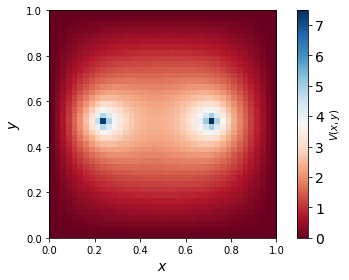

In [4]:
fig, ax = plt.subplots(1, 1)

I = ax.imshow(p.V, cmap = 'RdBu', extent = [0, 1, 0, 1])

ax.set_ylabel('$y$', fontsize = 14)
ax.set_xlabel('$x$', fontsize = 14)

cbar = fig.colorbar(I, label = '$V(x, y)$')
cbar.ax.tick_params(labelsize = 14)

fig.tight_layout();

Here, the color bar is indicative of the intensity of the potential.  As one would expect, the most potential exists at each particle and then between the two.  A further demonstration with a 3-D projection:

In [5]:
# This is fine because the box is symmetric.
# The code assumes symmetry so this isn't really
# a concern.
x = arange(0, p.h*(p.L + 2), p.h)
y = x

# A meshgrid, or the x and y values
# at each element of the lattice.
X, Y = meshgrid(x, y)

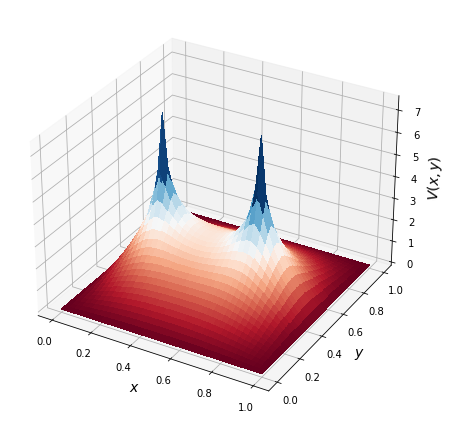

In [6]:
fig = plt.figure(1, figsize = (6, 6))

# Make a '3d' figure.
ax = fig.gca(projection='3d')

# Plot the surface.
surface = ax.plot_surface(X, Y, p.V, rstride = 1, cstride = 1, cmap='RdBu',
                        linewidth = 0, antialiased = False)


ax.set_xlabel('$x$', fontsize = 14)
ax.set_ylabel('$y$', fontsize = 14)
ax.set_zlabel('$V(x, y)$', fontsize = 14)

fig.tight_layout();

Ultimately this agrees with the above display.  This, however, gives it a bit of a more dynamic look such that the disparities in potential can be more easily displayed.  

Regardless, there are a few issues with this method.  Namely, that $V$ for the Jacobi is upper bounded by the value of $q$.  A plot of this can be seen below:

In [39]:
# Each step interval.
tsteps = arange(1, 21930)

# Storing the maximum potential as reference
max_V = zeros(tsteps.shape[0])

# We create a new Poisson object each time and store the max v after each step.
p = Poisson(L, rho, 'Jacobi')

# Calculating V for each Jacobi iteration:
for idx, step in enumerate(tsteps):
    p()
    
    # Storing it.
    max_V[idx] = max(p.V)

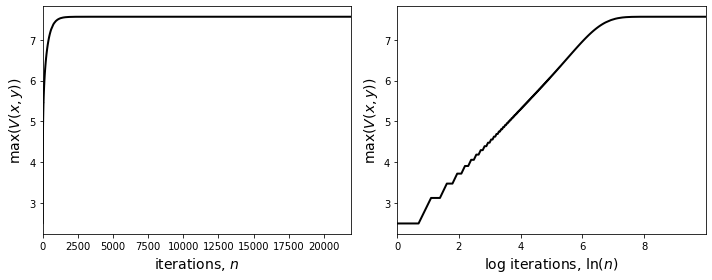

In [40]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

axs[0].plot(tsteps, max_V, lw = 2, c = 'k')

axs[0].set_xlim(0, 21930)

axs[0].set_ylabel('max($V(x, y)$)', fontsize = 14)
axs[0].set_xlabel('iterations, $n$', fontsize = 14)

axs[1].plot(log(tsteps), max_V, lw = 2, c = 'k')

axs[1].set_xlim(0, log(21930))

axs[1].set_ylabel('max($V(x, y)$)', fontsize = 14)
axs[1].set_xlabel('log iterations, $\ln(n)$', fontsize = 14)

fig.tight_layout()

We can see that max($V(x,y)$) is logarithmically and asymptotically approaching the scalar value of $q$ as $n$ increases, until about after 1000 iterations.  Therefore, for infinitely large $n$, the theoretical value of $V(x, y)$ should be $10$.  In practice, it appears to be approximately $7.5$.  Even though the units don't match up, assume that there's some hidden variables such that it does.  

Ultimately, it appears that the maximum value of the potential is partial to the resolution $L$ as well.  With more nodes comes more barriers for the potential to spread across, based on how the Jacobi works.  So, higher $L$ will more tightly concentrate the potential.  Although note that $h$ is more-so important for how well-defined the distribution is in the sense that it determines the differential spacing.  It would follow that a smaller $h$ value would provide a steeper structure, whereas larger $h$ provides a vague sense of the structure.  Truly, the most defined structure would come with effectively zero spacing and the maximum should be near $q$'s magntitude.

**(B.)** _theoretical solution_

Although we have a numerical solution, it is important to consider the theoretical solution.  Namely, the sum of the Coulomb potential's of both particles such that

\begin{equation}
V = kq\left[\dfrac{1}{R_1} + \dfrac{1}{R_2}\right]
\end{equation}

where $k$ is the Coulomb constant, $R_1$ is the position in the grid anywhere relative to the first particle, and $R_2$ similar to $R_1$, but for the second particle.  Note that the choice in $k$ is arbitrary, which will be explained later.  As such, we denote $k = 1$.

In [15]:
k = 1

R_1 = sqrt((X - 0.25)**2 + (Y - 0.5)**2)
R_2 = sqrt((X - 0.75)**2 + (Y - 0.5)**2)

In [12]:
V_1 = k*q/R_1
V_2 = k*q/R_2
V = V_1 + V_2

And the same graphs as above:

time to create a figure: 3.811 seconds


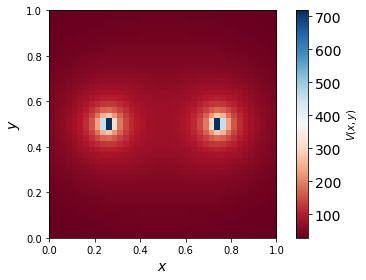

In [19]:
t0 = time.time()

fig, ax = plt.subplots(1, 1)

I = ax.imshow(V, cmap = 'RdBu', extent = [0, 1, 0, 1])

ax.set_ylabel('$y$', fontsize = 14)
ax.set_xlabel('$x$', fontsize = 14)

cbar = fig.colorbar(I, label = '$V(x, y)$')
cbar.ax.tick_params(labelsize = 14)

fig.tight_layout()

t1 = time.time()
print('time to create a figure: {:.3f} seconds'.format(t1 - t0))

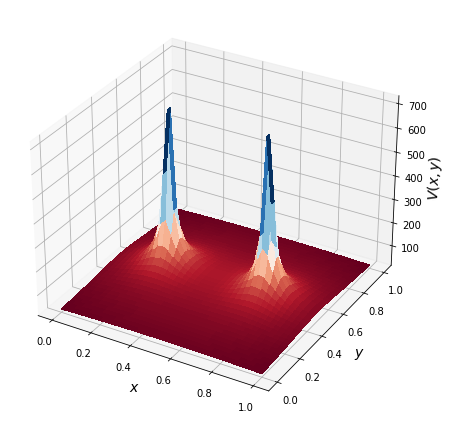

In [14]:
fig = plt.figure(1, figsize = (6, 6))

# Make a '3d' figure.
ax = fig.gca(projection='3d')

# Plot the surface.
surface = ax.plot_surface(X, Y, V, rstride = 1, cstride = 1, cmap='RdBu',
                        linewidth = 0, antialiased = False)


ax.set_xlabel('$x$', fontsize = 14)
ax.set_ylabel('$y$', fontsize = 14)
ax.set_zlabel('$V(x, y)$', fontsize = 14)

fig.tight_layout();

It is obvious that the numerical and theoretical solutions do not agree.  Not only in their peak value, but the overal structure of the distribution.  The first consideration is that the Jacobi method is an iterative solution; it repeats its calculations for $n$ iterations so inevitably it's going to spread out further as $n$ increases.  Whereas here, the theoretical solution is much tighter without an iterative techniques.  

Furthermore, the theoretical solution is not necessarily capped by the charge value.  Instead, $V$ here scales inversely proportional to the grid-spacing.  It will approach infinity near the point charges as $h$ decreases.  The surrounding areas are different because they're not approaching zero.  Really, they're moving away from zero towards $L$.  This is rather apparent since the theoretical solution is a function of $R$ and $R$ is in the denominator.  Basically, as the grid spacing becomes more fine, points on the grid will converge to the actual location of the particles such that the differential approaches zero.  

This is why $k$ is arbitrary.  Even if you picked the physical constant, theoretical $V$ will still scale more strongly with $h$.  Really, the theoretical solution is the one that makes most sense; the potential should diverge near $R = 0$, so the Jacobi solution not doing that and being capped is a failure of the method.   Nevertheless, grid spacing decreasing creates smaller distance values which causes the potential to diverge.  With the Jacobi, it can only accumulate as much potential as the charge it started with, although limitations due to the resolution are in play.

_Conclusion_

Although I don't have any error codes here, most of my limitations came in the computational power of the device.  I wasn't worried about the number of iterations, but more-so the resolution.  Since that scales $\mathcal{O}(N \times N)$ as opposed to just $\mathcal{O}(n)$, you naturally have to be weary of larger resolution.  Even though it is central into understanding the limit of the Jacobi, I can make a safe bet based on other's observations that the maximum Jacobi potential scales with resolution.  Otherwise, I opted for smaller iterations because of that one graph I posted.  The returns are nominal beyond a certain number of iterations, so it seemed contrarian.  

From time to time, I did also forget to remove `np.` from some of the class functions, but besides that I was cautious grooming through the code.  It really does reflect the limitations of the device by the number of numpy sub-libraries I have imported.  Interestingly enough, I think the most bottleneck came from creating a `matplotlib` figure object.  That's included in one of the figure boxes, however, as well as an early comparison.  For reference, the times that I had were:

 * Jacobi: 3.162 seconds (`L` = 38, `n` = 1000)
 * plot: 3.811 seconds

I can't really do the iterative method because it will create a new figure each time.  Other than that, I broke up the code into a few different cells when they could've been mostly together on a normal device.  This saves me from re-computing otherwise seemingly instant calculations.  Since I was only changing the figures for the most part, this saved me a lot of time.  

Regardless, this assignment was a good exploration into some of the more technical aspects of the Pi, but maybe not as thoroughly as it could have been.  I'm sure I could push the system to its limits by increasing `L` and `n`, but I saw no need in the aspect of this assignment's goals.

---